# DS3000 Lecture 12

### Admin
- Homework 6 posted on Tuesday and due on Friday
- Another Quiz at the end of this week!

### Content:
- Finish: Basic Data Summaries and data simulation
- Begin: Meaningful Distances and cross validation

## Continue Discussion Data:
### Sampling and Covariance/Correlation

Here's where we ended last time. Let's get our Pokemon dataset:

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale=1.2)

def make_lower(x):
    return str(x).lower()

df_poke = pd.read_csv('pokedata.csv')
df_poke = df_poke.rename(make_lower, axis = 1)
df_poke = df_poke.set_index('pokedex')
df_poke.head()

,pokemon,maintype,secondarytype,height,weight,damage,basespeed,attack,defense
pokedex,,,,,,,,,
1,Bulbasaur,Grass,Poison,24,25.2,45,45,49,49
2,Ivysaur,Grass,Poison,39,28.7,60,60,62,63
3,Venusaur,Grass,Poison,79,220.5,80,80,82,83
4,Charmander,Fire,NaN,24,18.7,39,65,52,43
5,Charmeleon,Fire,NaN,43,41.9,58,80,64,58


In [21]:
def estimate_distribution(x, n_bins=30):
    """ estimates a discrete distribution from a set of samples
    
    Args:
        x (np.array): a set of samples
        n_bins (int): number of outputs of discrete distribution
        
    Returns:
        items (np.array): items output from distribution
        prob (np.array): probability of each item
    """
    count_per_bin, bins = np.histogram(x, bins=n_bins)

    # normalize counts per bin
    prob = count_per_bin / sum(count_per_bin)

    # discard last element in bins
    # (let each bin be represented by its leftmost point)
    items = bins[:-1]
    
    return items, prob

In [22]:
items, prob = estimate_distribution([1, 1, 1, 1, 1, 2, 3, 3, 3, 3], n_bins=10)
items, prob

(array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8]),
 array([0.5, 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.4]))

In [23]:
n = 10000
sample_vector = np.random.choice(a=items, p=prob, size=n)

In [24]:
from collections import Counter

# Counter returns a dictionary which "counts" how many of every element appears
Counter(['a', 'a', 'a', 'b', 'b', 'c'])

Counter({'a': 3, 'b': 2, 'c': 1})

In [6]:
Counter(sample_vector)

Counter({1.0: 5038, 2.8: 3993, 2.0: 969})

## Great!  Let's produce (sample) some "fake" pokemon!

In [25]:
n_fake_pokemon = 50

# estimate distributions
item_wt, prob_wt = estimate_distribution(df_poke['weight'], n_bins=100)
item_ht, prob_ht = estimate_distribution(df_poke['height'], n_bins=100)

df_pokemon_fake = pd.DataFrame()
for fake_pokemon_idx in range(n_fake_pokemon):
    # generate a fake weight and height
    weight = np.random.choice(a=item_wt, p=prob_wt)
    height = np.random.choice(a=item_ht, p=prob_ht)
    
    # store new penguin in dataframe
    dict_fake = {'weight': weight, 
                 'height': height}
    df_pokemon_fake = pd.concat([df_pokemon_fake, pd.Series(dict_fake).to_frame().T], axis = 0)
     
df_pokemon_fake.head()

,weight,height
0,61.034,38.42
0,0.200,65.46
0,10.339,342.62
0,71.173,62.08
0,132.007,28.28


## Are our "fake" pokemon convincing?

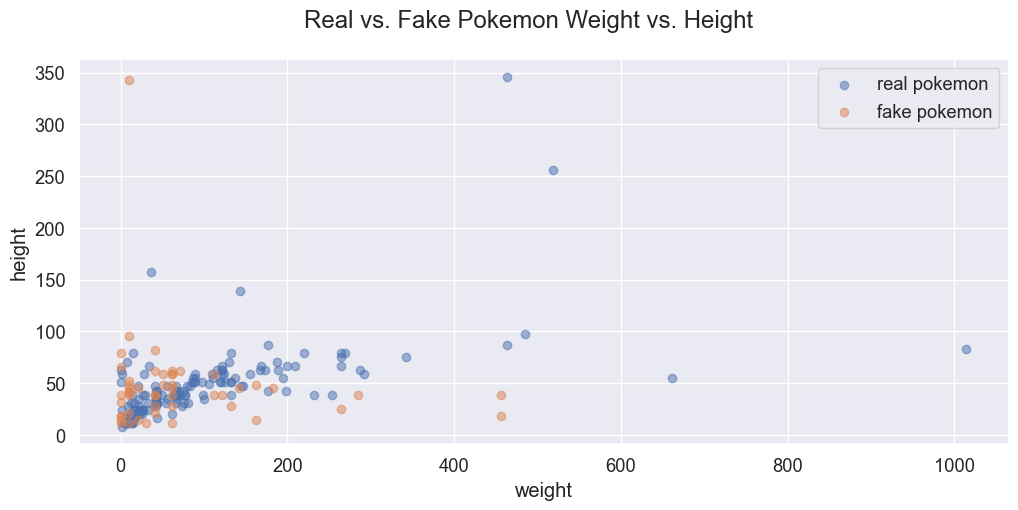

In [26]:
x_feat = 'weight'
y_feat = 'height'
plt.scatter(data=df_poke, x=x_feat, y=y_feat, alpha=.5, label='real pokemon')
plt.scatter(data=df_pokemon_fake, x=x_feat, y=y_feat, alpha=.5, label='fake pokemon')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.suptitle('Real vs. Fake Pokemon Weight vs. Height')
plt.gcf().set_size_inches((12, 5))

### Zoom in to check more carefully:

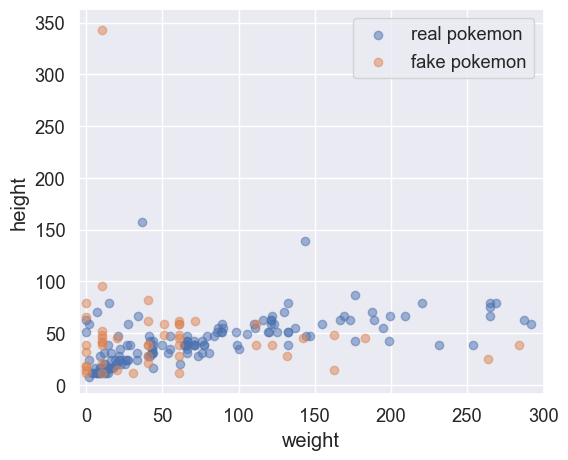

In [27]:
plt.scatter(data=df_poke, x=x_feat, y=y_feat, alpha=.5, label='real pokemon')
plt.scatter(data=df_pokemon_fake, x=x_feat, y=y_feat, alpha=.5, label='fake pokemon')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.xlim(-5, 300)
plt.gcf().set_size_inches((6, 5))

## What went wrong?

We need a way of encapsulating how `weight` and `height` are related; i.e. positively. As weight increases, pokemon height tends to increase. Our way of simulating the data **did not account for this**.

### Co-variance & correlation: Qualitatively
(How two values vary together)

The behavior between any two values x and y can be summarized in one of the three ways:
1. as x gets larger y typically gets larger too
    - ex: 
        - `x=temp on some day`
        - `y=number of people on the beach on the same day`
    - covariance & correlation is positive
2. as x gets larger y typically doesn't get larger or smaller
    - ex: 
        - `x=individual's favorite number`
        - `y=number of hot dogs that individual has eaten in their lifetime`
    - covariance & correlation is zero
3. as x gets larger, y typically gets smaller
    - ex: 
        - `x=average speed of driver on 10 mile commute`
        - `y=average commute time of driver on 10 mile commute`
    - covariance & correlation are negative

Covariance & Correlation are only defined between two values when the observations are somehow **linked**:
1. on the same **day**, we observe temp & beach population
1. on the same **individual**, we observe favortie number & hot dogs eaten
1. on the same **driver**, we observe speed and commute time

If we don't observe the data in pairs, correlation / covariance is not defined:
- `x=an individual's favorite number`
- `y=the temperature on a given day`

`x` is observed per individual while `y` is observed per day ... there isn't a way to "pair" every x with a y!

## Computing Co-variance ("by hand")

**Goal**: 

compute the covariance of x and y below:

In [28]:
df_car = pd.DataFrame({'car weight (x)': [-1, 0, 1, 2, 3],
                       'mpg (y)': [3, 1, -1, -3, -5]},
                      index=['car0', 'car1', 'car2', 'car3', 'car4'])
df_car

,car weight (x),mpg (y)
car0,-1,3
car1,0,1
car2,1,-1
car3,2,-3
car4,3,-5


**Sample covariance:**
$$ \texttt{cov}(x, y) = \frac{1}{N-1} \sum_i (x_i - \bar{x})(y_i - \bar{y})$$


**Compute:**

|      | x | y | $$ x_i - \bar{x}$$ | $$y - \bar{y}$$ | $$ (x_i - \bar{x})(y - \bar{y})$$ |
|-----:|---------------:|--------:|--------------------|-----------------|-----------------------------------|
| car0 |              -1 |       3 | -2                 | 4               | -8                                |
| car1 |              0 |       1 | -1                 | 2               | -2                                |
| car2 |              1 |       -1 | 0                  | 0               | 0                                 |
| car3 |              2 |       -3 | 1                  | -2              | -2                                |
| car4 |              3 |       -5 | 2                  | -4              | -8                                |

In [30]:
df_car.cov()

,car weight (x),mpg (y)
car weight (x),2.5,-5.0
mpg (y),-5.0,10.0


## Anatomy of a Covariance Matrix (computing covariance via computer)

In [31]:
df_car.cov()

,car weight (x),mpg (y)
car weight (x),2.5,-5.0
mpg (y),-5.0,10.0


A covariance matrix contains the covariance of every pair of elements:
    
|   |         x |         y |
|--:|----------:|----------:|
| x | cov(x, x) | cov(x, y) |
| y | cov(y, x) | cov(y, y) |

- Note 1: cov(x, y) = cov(y, x) (always, not just in this example)
- Note 2: cov(x, x) is the variance of x and itself

## Quick Example:

Each of the scatters below shows two features, each with a mean of 0.  Match the scatter above with the covariance matrices below (each scatter corresponds to a unique covariance matrix).

<img src="https://i.ibb.co/Jk9sp04/Screenshot-2024-07-21-114253.png" alt="Screenshot-2024-07-21-114253" border="0">

0: e
1: b
2: d
3: a
4: f
5: c

- on-diagnal are variance, they are always positive
- off-diagonal are covariance, can be positive, negative or zero
- If covariance are positive, then you will see an upward trend in the scatter plot
- If covariance are negative, then you will see an downward trend in the scatter plot
- If covariance are zero, then you will see a fuzzy ball in the scatter plot
- The trend is more clear means the absolute value of covariance is larger when the variance are the same
- the variance will only affect the range of the data

## Correlation (motivation)

Which has a more consistent relationship? (or maybe they're the same?)
- height of a person in `inches`
- height of a person in `cm`

or
- height of a person in `inches`
- height of a person in `feet`

What if we try and measure the relationship using covariance?

In [32]:
inch_to_cm = 2.54
inch_to_feet = 1/12

df_height = pd.DataFrame({'height_inches': [68, 69, 70, 72, 55, 77]})
df_height['height_cm'] = df_height['height_inches'] * inch_to_cm
df_height['height_feet'] = df_height['height_inches'] * inch_to_feet

df_height

,height_inches,height_cm,height_feet
0,68,172.72,5.666667
1,69,175.26,5.750000
2,70,177.80,5.833333
3,72,182.88,6.000000
4,55,139.70,4.583333
5,77,195.58,6.416667


In [33]:
df_height.cov()

,height_inches,height_cm,height_feet
height_inches,53.900000,136.906000,4.491667
height_cm,136.906000,347.741240,11.408833
height_feet,4.491667,11.408833,0.374306


- Covariance between `height_inches` and `height_cm` ~= 136
- Covariance between `height_inches` and `height_feet` ~= 4

So is there a stronger relationship between `height_inches` and `height_cm`? ...

<Axes: xlabel='height_inches', ylabel='height_cm'>

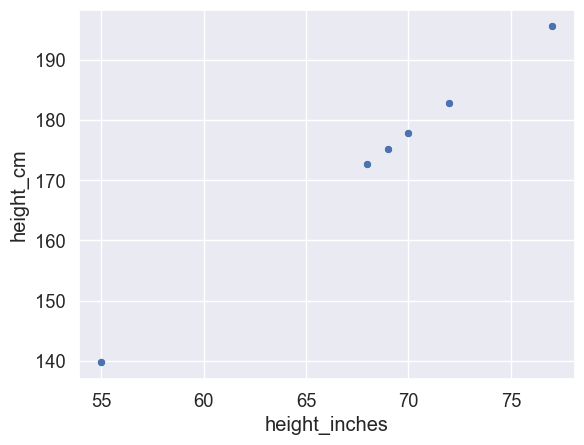

In [34]:
sns.scatterplot(data = df_height, x = 'height_inches', y = 'height_cm')

<Axes: xlabel='height_inches', ylabel='height_feet'>

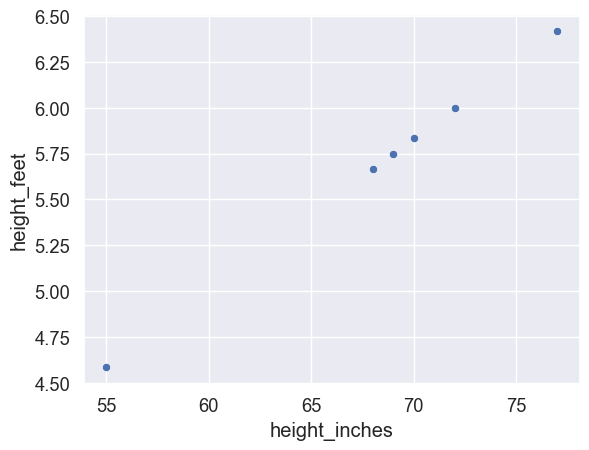

In [35]:
sns.scatterplot(data = df_height, x = 'height_inches', y = 'height_feet')

So is there a stronger relationship between `height_inches` and `height_cm`? ...

... not really.  Its just that covariance depends on the units we measure in.  Smaller units -> bigger values -> bigger covariance.

## The 'strongest' relationship between two variables

In some sense, this is the 'strongest' possible relationship.  When one variable increases, the other always does so too.  

**Helpful fact:**
The covariance is always smaller than the product of the standard deviations of both variables:

$$|cov(x,y)| \leq \sigma_x \sigma_y$$

In [36]:
# reminder: cov(height_inches, height_feet) ~= 4.49
# reminder: cov(height_inches, height_cm) ~= 136.82
df_height['height_inches'].std() * df_height['height_cm'].std()

136.90600000000006

In [37]:
df_height['height_inches'].std() * df_height['height_feet'].std()

4.491666666666667

### Question: What does it mean that this is the 'strongest' possible relationship, and that the covariances are as large as they can possibly be?

In [38]:
# for the correlation matrix, the on-diagonal values will always be 1
df_height.corr()

,height_inches,height_cm,height_feet
height_inches,1.0,1.0,1.0
height_cm,1.0,1.0,1.0
height_feet,1.0,1.0,1.0


## Correlation (Compute)

Remember, the biggest (and smallest) covariance we can possibly have is the product of the standard deviations:

$$|cov(x,y)| \leq \sigma_x \sigma_y$$

Correlation: "How big of a covariance do you have comapred to how big it could possibly be?"

$$corr(x,y) = \frac{\texttt{cov}(x, y)}{\sigma_x \sigma_y} $$

In doing so, it removes any effect of the scale of the data might have (e.g. changing units).

Since the covariance is always less or equal to $\sigma_x\sigma_y$, then the value of correlation is always between -1 to 1. 

- If the correlation is -1, then it indicates a perfect negative linear relationship
- If the correlation is 1, then it indicates a perfect positive linear relationship
- If the correlation is 0, then only indicates they may not have a linear relationship 

## Let's discuss Correlation some more

Correlations are shown above each scatter (credit: wikipedia)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1920px-Correlation_examples2.svg.png" alt="Drawing" style="width: 800px;"/>

Common misconception:

- if x and y are independent, then they're uncorrelated
- if x and y are uncorrelated, they need not be independent
    - (see examples in last row directly above)
    - If in your calculation, you get a correlation equal to 0. You should not make any conclusion before you plot the data. 

## The most important correlation/covariance slide: why did we go through all this trouble?

- mean describes where a feature typically is
- variance / standard deviation describes how consistently a feature stays near its mean
- correlation describes which relationship two values have:
    - when x increases, y typically increases
    - when x increases, y typically stays the same
    - when x increases, y typically decreases
    - **MOST IMPORTANTLY**: Just because two features have a correlation, **does not** mean they have anything to do with each other: [Spurious Correlations](http://www.tylervigen.com/spurious-correlations)

In [39]:
df_penguins = sns.load_dataset('penguins')
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [40]:
df_penguins.cov(numeric_only = True)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,29.807054,-2.534234,50.375765,2605.591912
bill_depth_mm,-2.534234,3.899808,-16.212950,-747.370093
flipper_length_mm,50.375765,-16.212950,197.731792,9824.416062
body_mass_g,2605.591912,-747.370093,9824.416062,643131.077327


In [41]:
df_penguins.corr(numeric_only = True)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


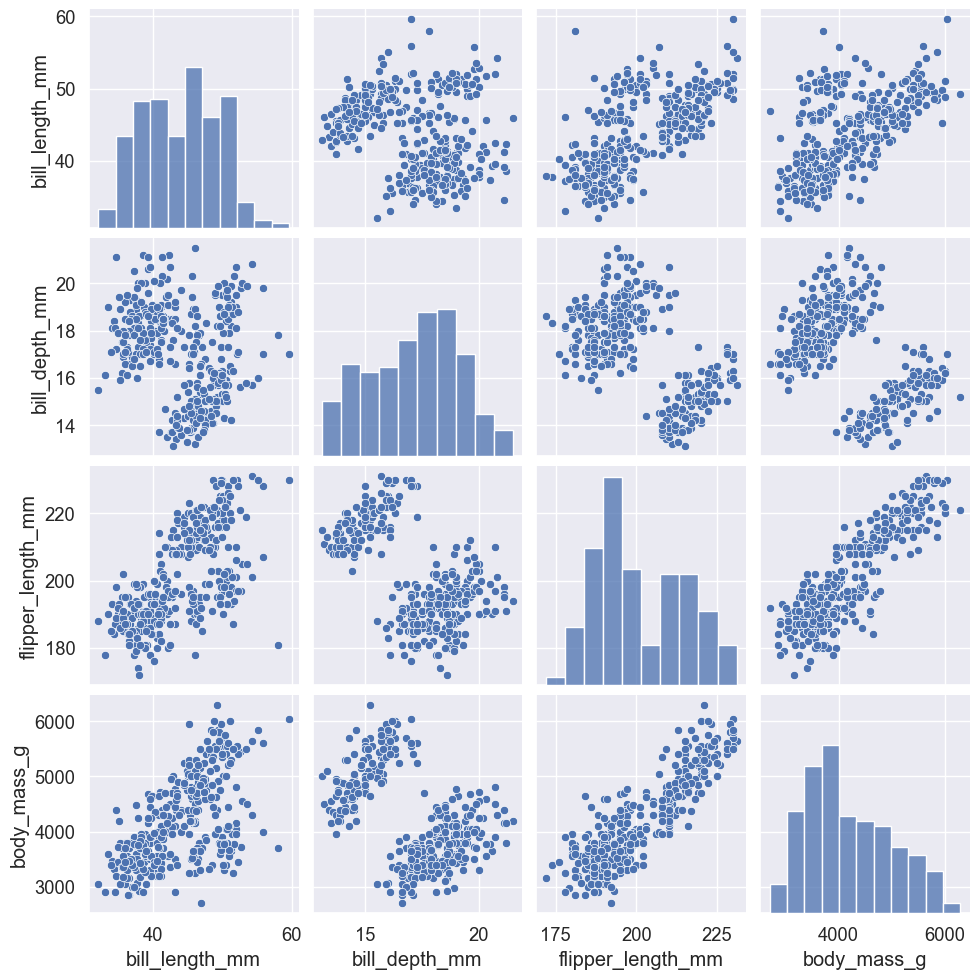

In [43]:
sns.pairplot(df_penguins)

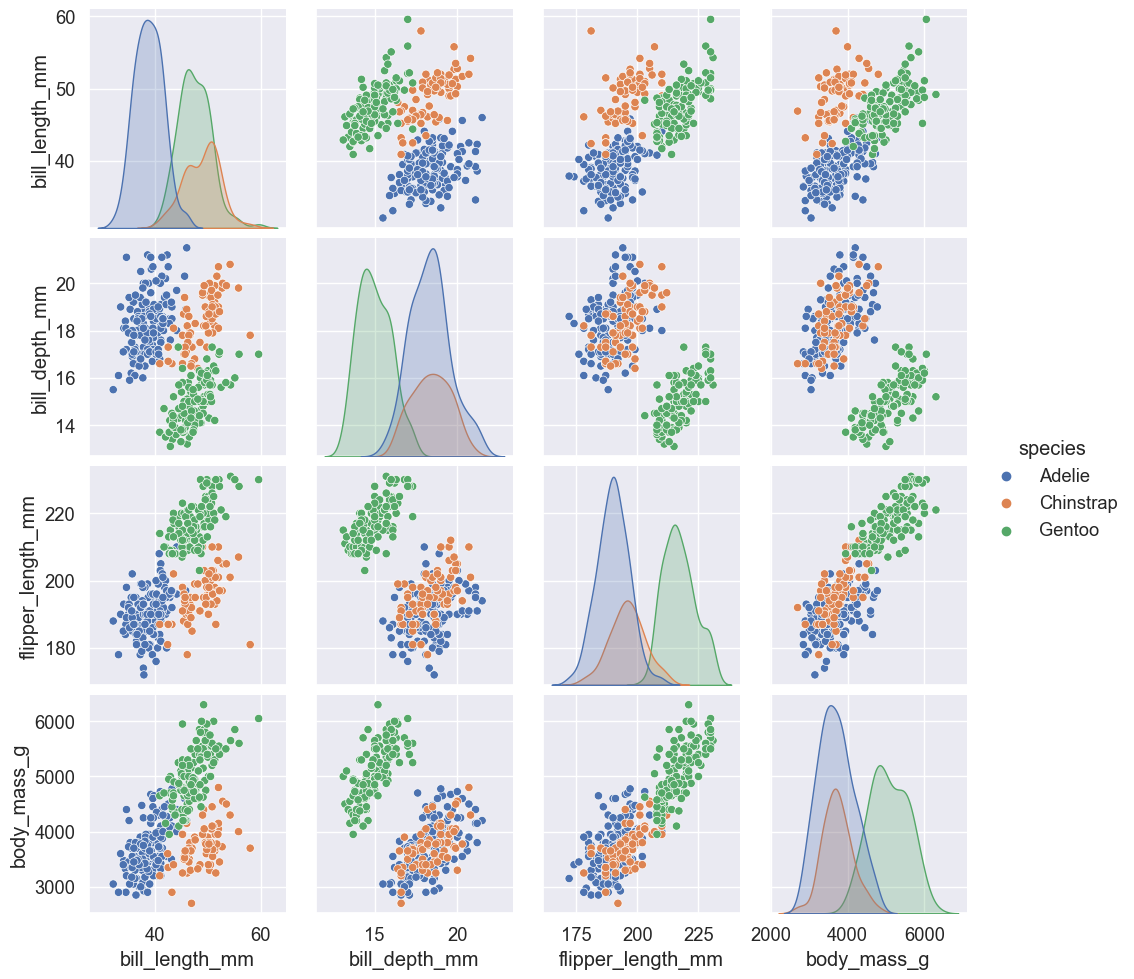

In [42]:
sns.pairplot(df_penguins, hue = 'species')

- Correlation cannot be interpreted by itself
- Always interepret with the plots
- Be careful about how the categorical features may affect the relationship
- Correlation only measure the linear relationship

## Organizing a data analysis project

What do we need to know about a data

- Introduction
  - Background (research question, why it is important or interesting)
  - Previous study
- Data
  - Source (where, do you collect it or scrap it aor find it) and format (csv or database or text)
  - Data size and features (numerical or categorical)
  - What is your target
  - EDA (make some data visualizations and interpret/guess the potential relationship between target and features)
- Model
    - Metrics
    - Model results
- Discussion
    - interpret the results
    - potential future works

# Statistics as a language

Knowing the meaning of these variables tells the story of the data (what it looks like, what relationships are in it, etc)

In the following example, we have data about ICU admission. Suppose my research question is "What factors may be related to the heart rate in ICU admissions?" Try to make three data viasualizations. 

Things you need to decide: 
- What features I want to choose for the data visualizaiton?
- What type of figures I will choose? 
- What information I want to achieve from the data visualization?
- ......

In [44]:
import pandas as pd
df = pd.read_csv("ICUAdmissions.csv")
print(df.head())

   ID  Status  Age  Sex  Race  Service  Cancer  Renal  Infection  CPR  ...  \
0   8       0   27    1     1        0       0      0          1    0  ...   
1  12       0   59    0     1        0       0      0          0    0  ...   
2  14       0   77    0     1        1       0      0          0    0  ...   
3  28       0   54    0     1        0       0      0          1    0  ...   
4  32       0   87    1     1        1       0      0          1    0  ...   

   HeartRate  Previous  Type  Fracture  PO2  PH  PCO2  Bicarbonate  \
0         88         0     1         0    0   0     0            0   
1         80         1     1         0    0   0     0            0   
2         70         0     0         0    0   0     0            0   
3        103         0     1         1    0   0     0            0   
4        154         1     1         0    0   0     0            0   

   Creatinine  Consciousness  
0           0              1  
1           0              1  
2           0    

In [46]:
df.shape

(200, 21)

The data has 200 ICU patients and each one records 21 features about those patients. The features include patients' physical measures (eg: gender and age), medical measure (eg: heart rate) and medical history (eg: cancer or not). The target we want to study is the heart rate. 

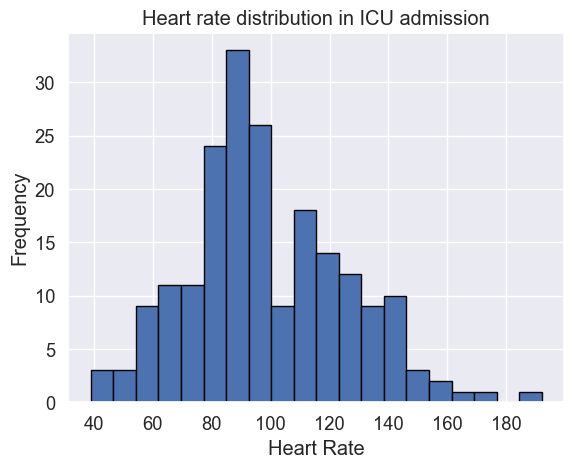

In [47]:
## Example 1 
# Since my target is the heart rate, then I should have an EDA just for the heart rate
plt.hist(df['HeartRate'], bins = 20, edgecolor = 'black')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.title('Heart rate distribution in ICU admission')
plt.show()

In [49]:
df['HeartRate'].mean()
df['HeartRate'].std()

26.829620153627584

This is a histogram for the heart rate distribution in the ICU admission. The range of the heart rate is within 40 to 190 and the mean is around 99. The standard deviation is about 27. The shape is symmetry but slightly skewed to right. 

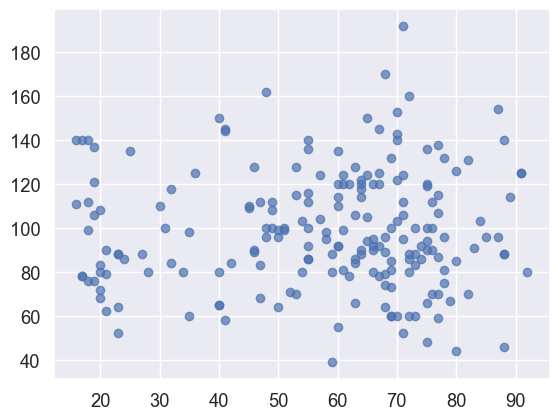

In [50]:
## Example 2

plt.scatter(df['Age'], df['HeartRate'], alpha = 0.7)
plt.show()

In [51]:
df['HeartRate'].corr(df['Age'])

0.03736843375054986

This is a scatter plot between heart rate and age for patients in ICU admission. The correlation value is around 0.04 and based on the scatter plot, it seems that there is no clear linear relationship between heart rate and age. 

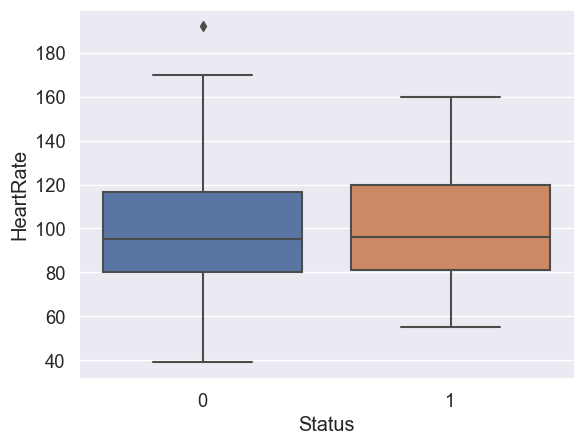

In [54]:
## Example 3
# Suppose you have one numerical feature and one categorical features, do a pair boxplot
sns.boxplot(x = "Status", y = 'HeartRate', data = df)
plt.show()

This is side-by-side boxplot for the distribution of heart rate among patients in ICU admission. It is divided into two groups for the patients survived through ICU (group 0) and not survived (group 1). Since the boxplot is overlapped, then there may not be significant difference between the heart rate among two groups. There is a potential outlier with high heart rate in the group 0 (survival). 

In [55]:
## Example 4
# when you have two cateogrical variable, side-by-side bar plot
counts = df.groupby(['Status', 'CPR']).size().unstack()
counts

CPR,0,1
Status,,
0,154,6
1,33,7


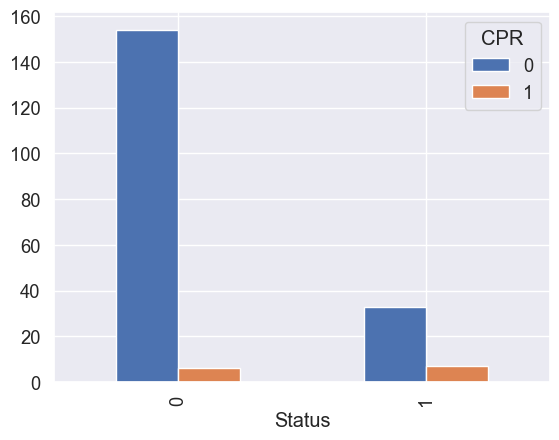

In [56]:
counts.plot(kind = 'bar', stacked = False)
plt.show()

This is the side-by-side bar plot for between whether the patient survived and whether they use CPR in the ICU. There are more people survived in the ICU and there are higher porpotion of people who need to use CPR in the non-survival group than the survival group. 